# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

## Reminder: Running within Floyd
floyd login
floyd run --mode jupyter --gpu --env tensorflow --data R5KrjnANiKVhLWAkpXhNBe:/input

In [1]:
!ls /input

img_align_celeba  mnist


In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


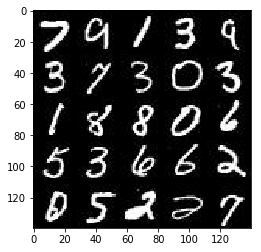

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

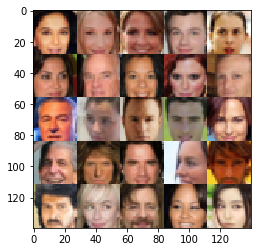

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def leaky_relu(layer, multiplier=0.1):
    '''
    x: Tensor
    multiplier: leak multiplier 
    
    Returns max tensor on input tensor. 
    '''
    return tf.maximum(layer, layer * multiplier)

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    dropout_rate = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #image size is 28x28x1 or 28x28x3
        d_layer1 = tf.layers.conv2d(images, 
                                    64, 
                                    3, 
                                    strides=2, 
                                    padding='same', 
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        d_layer1 = tf.layers.batch_normalization(d_layer1, training=True)
        d_layer1 = leaky_relu(d_layer1)
        d_layer1 = tf.layers.dropout(d_layer1, rate=dropout_rate)
        
        # Image size 7x7x128
        d_layer2 = tf.layers.conv2d(d_layer1, 
                                    128, 
                                    3, 
                                    strides=2, 
                                    padding='same', 
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        d_layer2 = tf.layers.batch_normalization(d_layer2, training=True)
        d_layer2 = leaky_relu(d_layer2)
        d_layer2 = tf.layers.dropout(d_layer2, rate=dropout_rate)
        
        # Image size 4x4x25
        d_layer3 = tf.layers.conv2d(d_layer2, 
                                    256, 
                                    3, 
                                    strides=2, 
                                    padding='same', 
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        d_layer3 = tf.layers.batch_normalization(d_layer3, training=True)
        d_layer3 = leaky_relu(d_layer3)
        d_layer3 = tf.layers.dropout(d_layer3, rate=dropout_rate)
        
        # Flattening
        flattenned = tf.reshape(d_layer3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattenned, 1)
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # Image size 7x7x1024
        g_layer1 = tf.layers.dense(z, 7*7*1024)
        g_layer1 = tf.reshape(g_layer1, (-1, 7,7,1024))
        g_layer1 = tf.layers.batch_normalization(g_layer1, training=is_train)
        g_layer1 = tf.nn.relu(g_layer1)
        
        # Image size 14x14x512
        g_layer2 = tf.layers.conv2d_transpose(g_layer1, 512, 3, strides=2, padding='same')
        g_layer2 = tf.layers.batch_normalization(g_layer2, training=is_train)
        g_layer2 = tf.nn.relu(g_layer2)
        
        # Image size 28x28x256
        g_layer3 = tf.layers.conv2d_transpose(g_layer2, 256, 3, strides=2, padding='same')
        g_layer3 = tf.layers.batch_normalization(g_layer3, training=is_train)
        g_layer3 = tf.nn.relu(g_layer3)
        
        g_layer3 = tf.layers.conv2d_transpose(g_layer3, out_channel_dim, 3, strides=2, padding='same')
        g_layer3 = tf.image.resize_images(g_layer3, size=(28,28))
        
        output = tf.nn.tanh(g_layer3, name='generator_main')
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_real_model, discriminator_real_logits  = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    smoothing = 0.1
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real_model)*(1-smoothing)))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.zeros_like(discriminator_fake_model)))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.ones_like(discriminator_fake_model)))
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
    discriminator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
    
    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_deps = [dep for dep in deps if dep.name.startswith('generator')]
    
    with tf.control_dependencies(generator_deps):
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return discriminator_opt, generator_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch += 1
                
                batch_images = 2*batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(g_opt, feed_dict = {
                    lr: learning_rate,
                    z_input: batch_z,
                })
                
                sess.run(d_opt, feed_dict = {
                    lr: learning_rate,
                    real_input: batch_images,
                    z_input: batch_z,
                })
                
                if batch % 10 == 0:
                        train_loss_d = sess.run(d_loss, feed_dict = {
                            real_input: batch_images,
                            z_input: batch_z,
                        })
                        train_loss_g = sess.run(g_loss, feed_dict = {
                            z_input: batch_z,
                        })
                        print("Epoch {}/{} - Step {} - ".format(epoch_i+1, epoch_count, batch),
                             "Discriminator Loss: {:.4f} - ".format(train_loss_d),
                             "Generator Loss: {:.4f}".format(train_loss_g))
                if batch % 100 == 0:
                    print("Sample outputs:")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Step 10 -  Discriminator Loss: 1.7448 -  Generator Loss: 0.4695
Epoch 1/2 - Step 20 -  Discriminator Loss: 0.6731 -  Generator Loss: 1.9139
Epoch 1/2 - Step 30 -  Discriminator Loss: 0.5535 -  Generator Loss: 2.3082
Epoch 1/2 - Step 40 -  Discriminator Loss: 0.6768 -  Generator Loss: 1.8712
Epoch 1/2 - Step 50 -  Discriminator Loss: 0.6198 -  Generator Loss: 2.2956
Epoch 1/2 - Step 60 -  Discriminator Loss: 0.5175 -  Generator Loss: 2.2647
Epoch 1/2 - Step 70 -  Discriminator Loss: 0.7980 -  Generator Loss: 1.3795
Epoch 1/2 - Step 80 -  Discriminator Loss: 1.1479 -  Generator Loss: 0.8450
Epoch 1/2 - Step 90 -  Discriminator Loss: 1.0992 -  Generator Loss: 0.8416
Epoch 1/2 - Step 100 -  Discriminator Loss: 0.9974 -  Generator Loss: 1.4141
Sample outputs:


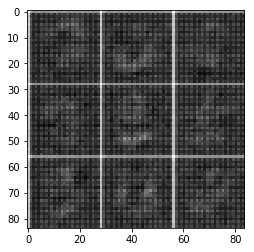

Epoch 1/2 - Step 110 -  Discriminator Loss: 1.0950 -  Generator Loss: 1.3825
Epoch 1/2 - Step 120 -  Discriminator Loss: 1.1227 -  Generator Loss: 1.2555
Epoch 1/2 - Step 130 -  Discriminator Loss: 1.1150 -  Generator Loss: 1.2393
Epoch 1/2 - Step 140 -  Discriminator Loss: 1.3112 -  Generator Loss: 1.5466
Epoch 1/2 - Step 150 -  Discriminator Loss: 1.0918 -  Generator Loss: 1.2574
Epoch 1/2 - Step 160 -  Discriminator Loss: 1.2437 -  Generator Loss: 1.4594
Epoch 1/2 - Step 170 -  Discriminator Loss: 1.3141 -  Generator Loss: 1.4293
Epoch 1/2 - Step 180 -  Discriminator Loss: 1.1484 -  Generator Loss: 1.1477
Epoch 1/2 - Step 190 -  Discriminator Loss: 1.0152 -  Generator Loss: 1.1729
Epoch 1/2 - Step 200 -  Discriminator Loss: 1.3560 -  Generator Loss: 1.6452
Sample outputs:


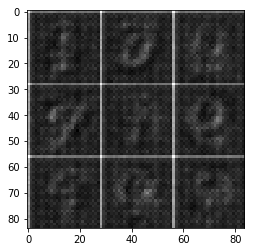

Epoch 1/2 - Step 210 -  Discriminator Loss: 1.1475 -  Generator Loss: 1.3473
Epoch 1/2 - Step 220 -  Discriminator Loss: 1.0684 -  Generator Loss: 1.1748
Epoch 1/2 - Step 230 -  Discriminator Loss: 1.0577 -  Generator Loss: 0.9674
Epoch 1/2 - Step 240 -  Discriminator Loss: 1.0003 -  Generator Loss: 0.9244
Epoch 1/2 - Step 250 -  Discriminator Loss: 0.9410 -  Generator Loss: 1.0557
Epoch 1/2 - Step 260 -  Discriminator Loss: 0.9181 -  Generator Loss: 1.0969
Epoch 1/2 - Step 270 -  Discriminator Loss: 1.1550 -  Generator Loss: 1.7483
Epoch 1/2 - Step 280 -  Discriminator Loss: 1.0314 -  Generator Loss: 1.5058
Epoch 1/2 - Step 290 -  Discriminator Loss: 1.0110 -  Generator Loss: 1.5359
Epoch 1/2 - Step 300 -  Discriminator Loss: 1.0295 -  Generator Loss: 1.5992
Sample outputs:


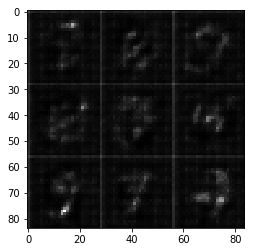

Epoch 1/2 - Step 310 -  Discriminator Loss: 0.8812 -  Generator Loss: 1.5554
Epoch 1/2 - Step 320 -  Discriminator Loss: 0.9664 -  Generator Loss: 1.5470
Epoch 1/2 - Step 330 -  Discriminator Loss: 1.1106 -  Generator Loss: 1.8040
Epoch 1/2 - Step 340 -  Discriminator Loss: 0.9911 -  Generator Loss: 1.6830
Epoch 1/2 - Step 350 -  Discriminator Loss: 0.7959 -  Generator Loss: 1.5597
Epoch 1/2 - Step 360 -  Discriminator Loss: 1.1640 -  Generator Loss: 2.2673
Epoch 1/2 - Step 370 -  Discriminator Loss: 0.9127 -  Generator Loss: 1.9941
Epoch 1/2 - Step 380 -  Discriminator Loss: 0.8513 -  Generator Loss: 1.9353
Epoch 1/2 - Step 390 -  Discriminator Loss: 0.9699 -  Generator Loss: 2.0454
Epoch 1/2 - Step 400 -  Discriminator Loss: 0.9883 -  Generator Loss: 2.0624
Sample outputs:


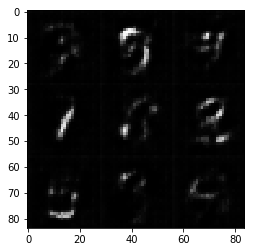

Epoch 1/2 - Step 410 -  Discriminator Loss: 0.7113 -  Generator Loss: 1.9682
Epoch 1/2 - Step 420 -  Discriminator Loss: 0.7710 -  Generator Loss: 1.8001
Epoch 1/2 - Step 430 -  Discriminator Loss: 0.8474 -  Generator Loss: 2.0353
Epoch 1/2 - Step 440 -  Discriminator Loss: 0.6474 -  Generator Loss: 1.6571
Epoch 1/2 - Step 450 -  Discriminator Loss: 0.9068 -  Generator Loss: 2.2283
Epoch 1/2 - Step 460 -  Discriminator Loss: 0.6450 -  Generator Loss: 1.7473
Epoch 1/2 - Step 470 -  Discriminator Loss: 0.7807 -  Generator Loss: 2.3816
Epoch 1/2 - Step 480 -  Discriminator Loss: 0.6050 -  Generator Loss: 1.7578
Epoch 1/2 - Step 490 -  Discriminator Loss: 0.5896 -  Generator Loss: 1.7862
Epoch 1/2 - Step 500 -  Discriminator Loss: 0.6957 -  Generator Loss: 1.3425
Sample outputs:


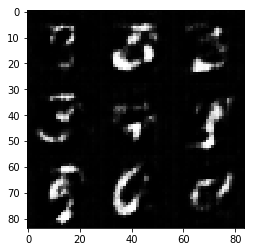

Epoch 1/2 - Step 510 -  Discriminator Loss: 0.6121 -  Generator Loss: 1.5889
Epoch 1/2 - Step 520 -  Discriminator Loss: 0.5978 -  Generator Loss: 1.7432
Epoch 1/2 - Step 530 -  Discriminator Loss: 0.5477 -  Generator Loss: 2.0623
Epoch 1/2 - Step 540 -  Discriminator Loss: 0.5576 -  Generator Loss: 1.7954
Epoch 1/2 - Step 550 -  Discriminator Loss: 0.7711 -  Generator Loss: 1.1438
Epoch 1/2 - Step 560 -  Discriminator Loss: 0.5365 -  Generator Loss: 1.9185
Epoch 1/2 - Step 570 -  Discriminator Loss: 0.5829 -  Generator Loss: 1.9446
Epoch 1/2 - Step 580 -  Discriminator Loss: 0.4512 -  Generator Loss: 2.4485
Epoch 1/2 - Step 590 -  Discriminator Loss: 0.9472 -  Generator Loss: 0.8647
Epoch 1/2 - Step 600 -  Discriminator Loss: 0.5775 -  Generator Loss: 2.0808
Sample outputs:


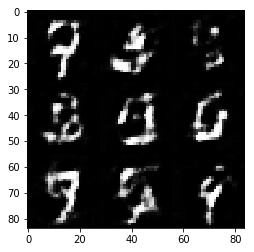

Epoch 1/2 - Step 610 -  Discriminator Loss: 0.6945 -  Generator Loss: 2.5014
Epoch 1/2 - Step 620 -  Discriminator Loss: 0.5660 -  Generator Loss: 2.2505
Epoch 1/2 - Step 630 -  Discriminator Loss: 0.5752 -  Generator Loss: 2.1931
Epoch 1/2 - Step 640 -  Discriminator Loss: 0.4774 -  Generator Loss: 2.5130
Epoch 1/2 - Step 650 -  Discriminator Loss: 0.8532 -  Generator Loss: 3.0322
Epoch 1/2 - Step 660 -  Discriminator Loss: 0.7647 -  Generator Loss: 2.3267
Epoch 1/2 - Step 670 -  Discriminator Loss: 0.7347 -  Generator Loss: 2.5534
Epoch 1/2 - Step 680 -  Discriminator Loss: 0.6451 -  Generator Loss: 2.7519
Epoch 1/2 - Step 690 -  Discriminator Loss: 1.0173 -  Generator Loss: 2.8688
Epoch 1/2 - Step 700 -  Discriminator Loss: 1.1585 -  Generator Loss: 3.0280
Sample outputs:


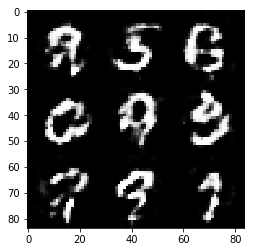

Epoch 1/2 - Step 710 -  Discriminator Loss: 0.5916 -  Generator Loss: 2.1578
Epoch 1/2 - Step 720 -  Discriminator Loss: 0.8131 -  Generator Loss: 2.9431
Epoch 1/2 - Step 730 -  Discriminator Loss: 0.5439 -  Generator Loss: 2.3667
Epoch 1/2 - Step 740 -  Discriminator Loss: 0.4549 -  Generator Loss: 2.4010
Epoch 1/2 - Step 750 -  Discriminator Loss: 0.6157 -  Generator Loss: 2.0485
Epoch 1/2 - Step 760 -  Discriminator Loss: 0.4453 -  Generator Loss: 2.6749
Epoch 1/2 - Step 770 -  Discriminator Loss: 0.4639 -  Generator Loss: 2.5588
Epoch 1/2 - Step 780 -  Discriminator Loss: 0.5099 -  Generator Loss: 2.7572
Epoch 1/2 - Step 790 -  Discriminator Loss: 0.4039 -  Generator Loss: 3.1860
Epoch 1/2 - Step 800 -  Discriminator Loss: 0.7559 -  Generator Loss: 2.5466
Sample outputs:


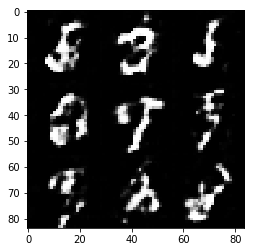

Epoch 1/2 - Step 810 -  Discriminator Loss: 0.6046 -  Generator Loss: 3.4250
Epoch 1/2 - Step 820 -  Discriminator Loss: 0.4395 -  Generator Loss: 2.9940
Epoch 1/2 - Step 830 -  Discriminator Loss: 0.4145 -  Generator Loss: 3.0509
Epoch 1/2 - Step 840 -  Discriminator Loss: 0.4290 -  Generator Loss: 2.8319
Epoch 1/2 - Step 850 -  Discriminator Loss: 0.4199 -  Generator Loss: 3.0430
Epoch 1/2 - Step 860 -  Discriminator Loss: 0.7016 -  Generator Loss: 3.8814
Epoch 1/2 - Step 870 -  Discriminator Loss: 0.4343 -  Generator Loss: 3.1339
Epoch 1/2 - Step 880 -  Discriminator Loss: 0.4457 -  Generator Loss: 3.1445
Epoch 1/2 - Step 890 -  Discriminator Loss: 0.3994 -  Generator Loss: 3.1584
Epoch 1/2 - Step 900 -  Discriminator Loss: 0.4008 -  Generator Loss: 3.0553
Sample outputs:


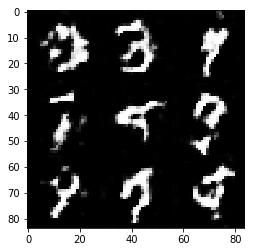

Epoch 1/2 - Step 910 -  Discriminator Loss: 0.4034 -  Generator Loss: 3.1013
Epoch 1/2 - Step 920 -  Discriminator Loss: 0.4031 -  Generator Loss: 3.3526
Epoch 1/2 - Step 930 -  Discriminator Loss: 0.4100 -  Generator Loss: 2.8629
Epoch 2/2 - Step 940 -  Discriminator Loss: 0.3973 -  Generator Loss: 3.1341
Epoch 2/2 - Step 950 -  Discriminator Loss: 0.4023 -  Generator Loss: 3.1276
Epoch 2/2 - Step 960 -  Discriminator Loss: 1.4449 -  Generator Loss: 4.3091
Epoch 2/2 - Step 970 -  Discriminator Loss: 0.3850 -  Generator Loss: 3.4091
Epoch 2/2 - Step 980 -  Discriminator Loss: 0.4685 -  Generator Loss: 3.3275
Epoch 2/2 - Step 990 -  Discriminator Loss: 0.4074 -  Generator Loss: 3.1111
Epoch 2/2 - Step 1000 -  Discriminator Loss: 0.4361 -  Generator Loss: 3.0237
Sample outputs:


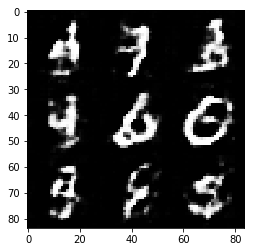

Epoch 2/2 - Step 1010 -  Discriminator Loss: 0.3964 -  Generator Loss: 3.2968
Epoch 2/2 - Step 1020 -  Discriminator Loss: 0.3785 -  Generator Loss: 3.7743
Epoch 2/2 - Step 1030 -  Discriminator Loss: 0.6404 -  Generator Loss: 3.7107
Epoch 2/2 - Step 1040 -  Discriminator Loss: 1.1485 -  Generator Loss: 1.9102
Epoch 2/2 - Step 1050 -  Discriminator Loss: 0.5169 -  Generator Loss: 2.9636
Epoch 2/2 - Step 1060 -  Discriminator Loss: 0.4449 -  Generator Loss: 2.7657
Epoch 2/2 - Step 1070 -  Discriminator Loss: 0.3980 -  Generator Loss: 3.1747
Epoch 2/2 - Step 1080 -  Discriminator Loss: 0.3742 -  Generator Loss: 3.6470
Epoch 2/2 - Step 1090 -  Discriminator Loss: 0.3730 -  Generator Loss: 3.9640
Epoch 2/2 - Step 1100 -  Discriminator Loss: 0.4471 -  Generator Loss: 3.0179
Sample outputs:


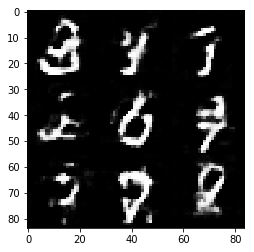

Epoch 2/2 - Step 1110 -  Discriminator Loss: 0.3546 -  Generator Loss: 4.3805
Epoch 2/2 - Step 1120 -  Discriminator Loss: 1.3905 -  Generator Loss: 4.4856
Epoch 2/2 - Step 1130 -  Discriminator Loss: 0.3786 -  Generator Loss: 4.0132
Epoch 2/2 - Step 1140 -  Discriminator Loss: 0.4369 -  Generator Loss: 3.0149
Epoch 2/2 - Step 1150 -  Discriminator Loss: 0.4241 -  Generator Loss: 3.0649
Epoch 2/2 - Step 1160 -  Discriminator Loss: 0.4195 -  Generator Loss: 3.2021
Epoch 2/2 - Step 1170 -  Discriminator Loss: 0.4001 -  Generator Loss: 3.3172
Epoch 2/2 - Step 1180 -  Discriminator Loss: 0.3988 -  Generator Loss: 3.3134
Epoch 2/2 - Step 1190 -  Discriminator Loss: 0.3999 -  Generator Loss: 3.1275
Epoch 2/2 - Step 1200 -  Discriminator Loss: 0.8113 -  Generator Loss: 3.0258
Sample outputs:


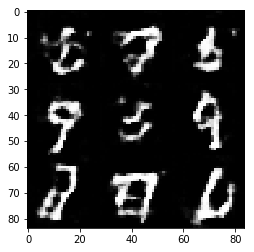

Epoch 2/2 - Step 1210 -  Discriminator Loss: 0.3999 -  Generator Loss: 3.3135
Epoch 2/2 - Step 1220 -  Discriminator Loss: 0.4714 -  Generator Loss: 2.4138
Epoch 2/2 - Step 1230 -  Discriminator Loss: 0.4827 -  Generator Loss: 2.5523
Epoch 2/2 - Step 1240 -  Discriminator Loss: 0.3663 -  Generator Loss: 4.4269
Epoch 2/2 - Step 1250 -  Discriminator Loss: 0.4395 -  Generator Loss: 2.8509
Epoch 2/2 - Step 1260 -  Discriminator Loss: 0.3883 -  Generator Loss: 3.8906
Epoch 2/2 - Step 1270 -  Discriminator Loss: 0.4846 -  Generator Loss: 2.7146
Epoch 2/2 - Step 1280 -  Discriminator Loss: 0.6124 -  Generator Loss: 3.1756
Epoch 2/2 - Step 1290 -  Discriminator Loss: 0.4583 -  Generator Loss: 2.7180
Epoch 2/2 - Step 1300 -  Discriminator Loss: 0.4236 -  Generator Loss: 3.0034
Sample outputs:


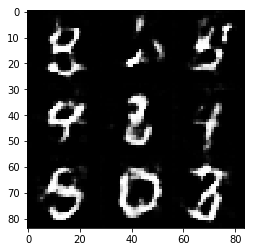

Epoch 2/2 - Step 1310 -  Discriminator Loss: 0.4293 -  Generator Loss: 2.9543
Epoch 2/2 - Step 1320 -  Discriminator Loss: 0.5233 -  Generator Loss: 3.5356
Epoch 2/2 - Step 1330 -  Discriminator Loss: 0.3764 -  Generator Loss: 4.0803
Epoch 2/2 - Step 1340 -  Discriminator Loss: 0.4451 -  Generator Loss: 2.6572
Epoch 2/2 - Step 1350 -  Discriminator Loss: 0.4172 -  Generator Loss: 2.9372
Epoch 2/2 - Step 1360 -  Discriminator Loss: 0.4855 -  Generator Loss: 2.7411
Epoch 2/2 - Step 1370 -  Discriminator Loss: 0.4144 -  Generator Loss: 3.1373
Epoch 2/2 - Step 1380 -  Discriminator Loss: 0.4891 -  Generator Loss: 2.9753
Epoch 2/2 - Step 1390 -  Discriminator Loss: 0.3781 -  Generator Loss: 3.6524
Epoch 2/2 - Step 1400 -  Discriminator Loss: 0.4512 -  Generator Loss: 2.9282
Sample outputs:


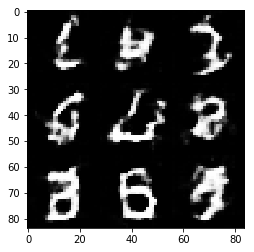

Epoch 2/2 - Step 1410 -  Discriminator Loss: 0.4230 -  Generator Loss: 3.1131
Epoch 2/2 - Step 1420 -  Discriminator Loss: 0.4036 -  Generator Loss: 3.1612
Epoch 2/2 - Step 1430 -  Discriminator Loss: 0.4948 -  Generator Loss: 2.4843
Epoch 2/2 - Step 1440 -  Discriminator Loss: 0.4120 -  Generator Loss: 3.2845
Epoch 2/2 - Step 1450 -  Discriminator Loss: 0.4016 -  Generator Loss: 3.2317
Epoch 2/2 - Step 1460 -  Discriminator Loss: 0.5842 -  Generator Loss: 3.4792
Epoch 2/2 - Step 1470 -  Discriminator Loss: 0.3631 -  Generator Loss: 4.1419
Epoch 2/2 - Step 1480 -  Discriminator Loss: 0.3815 -  Generator Loss: 3.5587
Epoch 2/2 - Step 1490 -  Discriminator Loss: 0.4791 -  Generator Loss: 2.5523
Epoch 2/2 - Step 1500 -  Discriminator Loss: 0.4456 -  Generator Loss: 2.9426
Sample outputs:


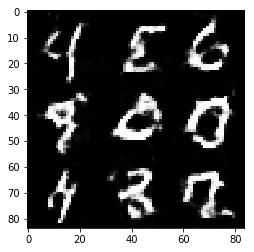

Epoch 2/2 - Step 1510 -  Discriminator Loss: 0.3901 -  Generator Loss: 3.3190
Epoch 2/2 - Step 1520 -  Discriminator Loss: 0.4657 -  Generator Loss: 2.3170
Epoch 2/2 - Step 1530 -  Discriminator Loss: 0.4491 -  Generator Loss: 2.5841
Epoch 2/2 - Step 1540 -  Discriminator Loss: 0.4496 -  Generator Loss: 2.7753
Epoch 2/2 - Step 1550 -  Discriminator Loss: 0.4127 -  Generator Loss: 3.2794
Epoch 2/2 - Step 1560 -  Discriminator Loss: 0.4025 -  Generator Loss: 3.5671
Epoch 2/2 - Step 1570 -  Discriminator Loss: 0.4692 -  Generator Loss: 2.4965
Epoch 2/2 - Step 1580 -  Discriminator Loss: 1.7059 -  Generator Loss: 3.4212
Epoch 2/2 - Step 1590 -  Discriminator Loss: 0.3737 -  Generator Loss: 4.5408
Epoch 2/2 - Step 1600 -  Discriminator Loss: 0.3828 -  Generator Loss: 3.7091
Sample outputs:


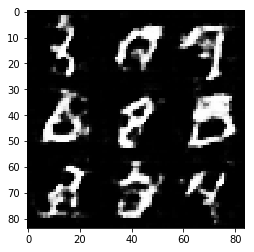

Epoch 2/2 - Step 1610 -  Discriminator Loss: 0.5234 -  Generator Loss: 2.2202
Epoch 2/2 - Step 1620 -  Discriminator Loss: 0.9904 -  Generator Loss: 2.3056
Epoch 2/2 - Step 1630 -  Discriminator Loss: 0.4273 -  Generator Loss: 4.0775
Epoch 2/2 - Step 1640 -  Discriminator Loss: 0.4053 -  Generator Loss: 3.2781
Epoch 2/2 - Step 1650 -  Discriminator Loss: 0.4279 -  Generator Loss: 2.8938
Epoch 2/2 - Step 1660 -  Discriminator Loss: 0.4150 -  Generator Loss: 3.0006
Epoch 2/2 - Step 1670 -  Discriminator Loss: 0.4468 -  Generator Loss: 2.7311
Epoch 2/2 - Step 1680 -  Discriminator Loss: 1.0262 -  Generator Loss: 2.8697
Epoch 2/2 - Step 1690 -  Discriminator Loss: 1.0404 -  Generator Loss: 2.2763
Epoch 2/2 - Step 1700 -  Discriminator Loss: 0.5680 -  Generator Loss: 2.2050
Sample outputs:


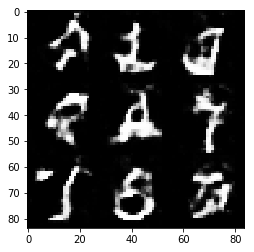

Epoch 2/2 - Step 1710 -  Discriminator Loss: 0.4012 -  Generator Loss: 4.2864
Epoch 2/2 - Step 1720 -  Discriminator Loss: 0.4298 -  Generator Loss: 2.7812
Epoch 2/2 - Step 1730 -  Discriminator Loss: 0.4323 -  Generator Loss: 2.8671
Epoch 2/2 - Step 1740 -  Discriminator Loss: 0.4267 -  Generator Loss: 2.9373
Epoch 2/2 - Step 1750 -  Discriminator Loss: 0.5706 -  Generator Loss: 2.5412
Epoch 2/2 - Step 1760 -  Discriminator Loss: 0.3751 -  Generator Loss: 4.1865
Epoch 2/2 - Step 1770 -  Discriminator Loss: 0.4893 -  Generator Loss: 2.5566
Epoch 2/2 - Step 1780 -  Discriminator Loss: 0.4891 -  Generator Loss: 2.3630
Epoch 2/2 - Step 1790 -  Discriminator Loss: 0.4699 -  Generator Loss: 2.3902
Epoch 2/2 - Step 1800 -  Discriminator Loss: 0.6773 -  Generator Loss: 2.7317
Sample outputs:


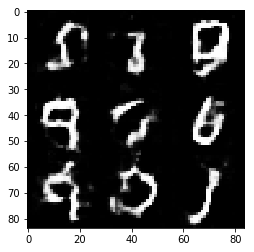

Epoch 2/2 - Step 1810 -  Discriminator Loss: 0.3719 -  Generator Loss: 5.0037
Epoch 2/2 - Step 1820 -  Discriminator Loss: 0.4341 -  Generator Loss: 2.9505
Epoch 2/2 - Step 1830 -  Discriminator Loss: 0.8258 -  Generator Loss: 3.1161
Epoch 2/2 - Step 1840 -  Discriminator Loss: 0.4712 -  Generator Loss: 2.6339
Epoch 2/2 - Step 1850 -  Discriminator Loss: 0.4443 -  Generator Loss: 2.8316
Epoch 2/2 - Step 1860 -  Discriminator Loss: 0.4341 -  Generator Loss: 2.9068
Epoch 2/2 - Step 1870 -  Discriminator Loss: 0.4179 -  Generator Loss: 3.0667


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Step 10 -  Discriminator Loss: 5.1142 -  Generator Loss: 0.0265
Epoch 1/1 - Step 20 -  Discriminator Loss: 2.1071 -  Generator Loss: 0.5331
Epoch 1/1 - Step 30 -  Discriminator Loss: 1.5049 -  Generator Loss: 1.0437
Epoch 1/1 - Step 40 -  Discriminator Loss: 1.5725 -  Generator Loss: 0.9118
Epoch 1/1 - Step 50 -  Discriminator Loss: 1.1986 -  Generator Loss: 1.3576
Epoch 1/1 - Step 60 -  Discriminator Loss: 0.9356 -  Generator Loss: 1.5049
Epoch 1/1 - Step 70 -  Discriminator Loss: 1.0681 -  Generator Loss: 1.6488
Epoch 1/1 - Step 80 -  Discriminator Loss: 0.9682 -  Generator Loss: 1.7295
Epoch 1/1 - Step 90 -  Discriminator Loss: 1.0491 -  Generator Loss: 1.3942
Epoch 1/1 - Step 100 -  Discriminator Loss: 1.1376 -  Generator Loss: 1.0542
Sample outputs:


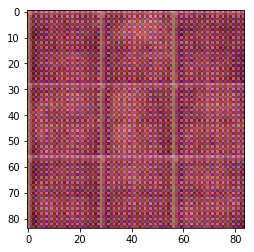

Epoch 1/1 - Step 110 -  Discriminator Loss: 1.0882 -  Generator Loss: 1.4662
Epoch 1/1 - Step 120 -  Discriminator Loss: 1.1063 -  Generator Loss: 1.0196
Epoch 1/1 - Step 130 -  Discriminator Loss: 0.9781 -  Generator Loss: 1.2829
Epoch 1/1 - Step 140 -  Discriminator Loss: 1.1665 -  Generator Loss: 1.3536
Epoch 1/1 - Step 150 -  Discriminator Loss: 1.3547 -  Generator Loss: 1.3685
Epoch 1/1 - Step 160 -  Discriminator Loss: 1.4982 -  Generator Loss: 1.0293
Epoch 1/1 - Step 170 -  Discriminator Loss: 1.3636 -  Generator Loss: 0.9084
Epoch 1/1 - Step 180 -  Discriminator Loss: 1.4169 -  Generator Loss: 1.0028
Epoch 1/1 - Step 190 -  Discriminator Loss: 1.4425 -  Generator Loss: 0.7271
Epoch 1/1 - Step 200 -  Discriminator Loss: 1.3901 -  Generator Loss: 1.0782
Sample outputs:


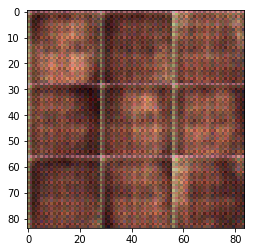

Epoch 1/1 - Step 210 -  Discriminator Loss: 1.1252 -  Generator Loss: 1.1642
Epoch 1/1 - Step 220 -  Discriminator Loss: 1.1319 -  Generator Loss: 1.0921
Epoch 1/1 - Step 230 -  Discriminator Loss: 1.4443 -  Generator Loss: 1.0641
Epoch 1/1 - Step 240 -  Discriminator Loss: 1.5742 -  Generator Loss: 1.0558
Epoch 1/1 - Step 250 -  Discriminator Loss: 1.3291 -  Generator Loss: 1.0731
Epoch 1/1 - Step 260 -  Discriminator Loss: 1.3964 -  Generator Loss: 1.0161
Epoch 1/1 - Step 270 -  Discriminator Loss: 1.4158 -  Generator Loss: 0.8152
Epoch 1/1 - Step 280 -  Discriminator Loss: 1.4163 -  Generator Loss: 0.9469
Epoch 1/1 - Step 290 -  Discriminator Loss: 1.4120 -  Generator Loss: 0.9294
Epoch 1/1 - Step 300 -  Discriminator Loss: 1.5070 -  Generator Loss: 0.8632
Sample outputs:


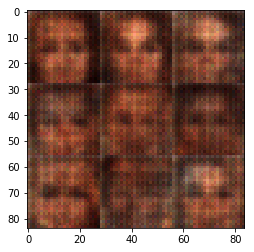

Epoch 1/1 - Step 310 -  Discriminator Loss: 1.4167 -  Generator Loss: 0.8111
Epoch 1/1 - Step 320 -  Discriminator Loss: 1.5415 -  Generator Loss: 1.0796
Epoch 1/1 - Step 330 -  Discriminator Loss: 1.3771 -  Generator Loss: 1.0105
Epoch 1/1 - Step 340 -  Discriminator Loss: 1.4388 -  Generator Loss: 1.0813
Epoch 1/1 - Step 350 -  Discriminator Loss: 1.3525 -  Generator Loss: 0.9047
Epoch 1/1 - Step 360 -  Discriminator Loss: 1.3378 -  Generator Loss: 0.9613
Epoch 1/1 - Step 370 -  Discriminator Loss: 1.1706 -  Generator Loss: 0.8516
Epoch 1/1 - Step 380 -  Discriminator Loss: 1.2722 -  Generator Loss: 0.9714
Epoch 1/1 - Step 390 -  Discriminator Loss: 1.1769 -  Generator Loss: 1.0399
Epoch 1/1 - Step 400 -  Discriminator Loss: 1.3438 -  Generator Loss: 0.8807
Sample outputs:


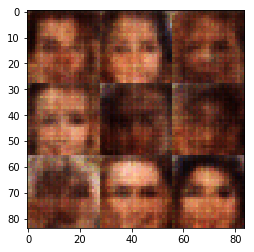

Epoch 1/1 - Step 410 -  Discriminator Loss: 1.4758 -  Generator Loss: 1.3170
Epoch 1/1 - Step 420 -  Discriminator Loss: 1.2119 -  Generator Loss: 0.8418
Epoch 1/1 - Step 430 -  Discriminator Loss: 1.1322 -  Generator Loss: 1.0194
Epoch 1/1 - Step 440 -  Discriminator Loss: 1.1941 -  Generator Loss: 0.9282
Epoch 1/1 - Step 450 -  Discriminator Loss: 1.2159 -  Generator Loss: 1.3186
Epoch 1/1 - Step 460 -  Discriminator Loss: 1.1698 -  Generator Loss: 1.1808
Epoch 1/1 - Step 470 -  Discriminator Loss: 1.2020 -  Generator Loss: 1.1276
Epoch 1/1 - Step 480 -  Discriminator Loss: 0.9589 -  Generator Loss: 1.0543
Epoch 1/1 - Step 490 -  Discriminator Loss: 1.4989 -  Generator Loss: 1.2662
Epoch 1/1 - Step 500 -  Discriminator Loss: 1.2072 -  Generator Loss: 1.4309
Sample outputs:


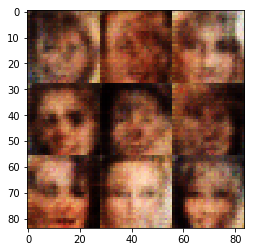

Epoch 1/1 - Step 510 -  Discriminator Loss: 1.3040 -  Generator Loss: 1.2287
Epoch 1/1 - Step 520 -  Discriminator Loss: 1.2281 -  Generator Loss: 1.4586
Epoch 1/1 - Step 530 -  Discriminator Loss: 1.1440 -  Generator Loss: 1.1180
Epoch 1/1 - Step 540 -  Discriminator Loss: 1.1821 -  Generator Loss: 1.1072
Epoch 1/1 - Step 550 -  Discriminator Loss: 0.9673 -  Generator Loss: 1.0804
Epoch 1/1 - Step 560 -  Discriminator Loss: 1.0671 -  Generator Loss: 1.2161
Epoch 1/1 - Step 570 -  Discriminator Loss: 0.7737 -  Generator Loss: 1.4304
Epoch 1/1 - Step 580 -  Discriminator Loss: 0.8718 -  Generator Loss: 1.3743
Epoch 1/1 - Step 590 -  Discriminator Loss: 0.8469 -  Generator Loss: 1.1950
Epoch 1/1 - Step 600 -  Discriminator Loss: 0.9936 -  Generator Loss: 1.1165
Sample outputs:


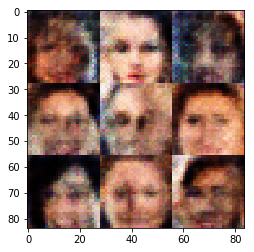

Epoch 1/1 - Step 610 -  Discriminator Loss: 0.7869 -  Generator Loss: 1.3165
Epoch 1/1 - Step 620 -  Discriminator Loss: 1.0516 -  Generator Loss: 1.6046
Epoch 1/1 - Step 630 -  Discriminator Loss: 1.0514 -  Generator Loss: 1.3540
Epoch 1/1 - Step 640 -  Discriminator Loss: 1.4444 -  Generator Loss: 1.1119
Epoch 1/1 - Step 650 -  Discriminator Loss: 1.2663 -  Generator Loss: 1.6330
Epoch 1/1 - Step 660 -  Discriminator Loss: 1.3130 -  Generator Loss: 0.8197
Epoch 1/1 - Step 670 -  Discriminator Loss: 0.9398 -  Generator Loss: 1.3052
Epoch 1/1 - Step 680 -  Discriminator Loss: 1.1257 -  Generator Loss: 1.5266
Epoch 1/1 - Step 690 -  Discriminator Loss: 1.1373 -  Generator Loss: 1.0411
Epoch 1/1 - Step 700 -  Discriminator Loss: 1.3375 -  Generator Loss: 2.1517
Sample outputs:


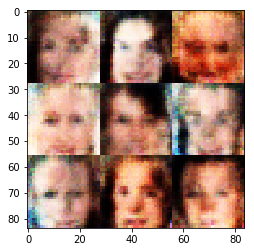

Epoch 1/1 - Step 710 -  Discriminator Loss: 1.1103 -  Generator Loss: 1.4721
Epoch 1/1 - Step 720 -  Discriminator Loss: 0.7322 -  Generator Loss: 1.5514
Epoch 1/1 - Step 730 -  Discriminator Loss: 1.1071 -  Generator Loss: 1.5876
Epoch 1/1 - Step 740 -  Discriminator Loss: 0.8888 -  Generator Loss: 1.3050
Epoch 1/1 - Step 750 -  Discriminator Loss: 0.8553 -  Generator Loss: 1.4346
Epoch 1/1 - Step 760 -  Discriminator Loss: 1.0378 -  Generator Loss: 1.7470
Epoch 1/1 - Step 770 -  Discriminator Loss: 0.9855 -  Generator Loss: 1.1137
Epoch 1/1 - Step 780 -  Discriminator Loss: 1.1452 -  Generator Loss: 1.4441
Epoch 1/1 - Step 790 -  Discriminator Loss: 1.3952 -  Generator Loss: 1.2256
Epoch 1/1 - Step 800 -  Discriminator Loss: 1.2112 -  Generator Loss: 0.9706
Sample outputs:


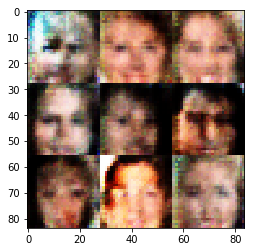

Epoch 1/1 - Step 810 -  Discriminator Loss: 1.2588 -  Generator Loss: 1.8595
Epoch 1/1 - Step 820 -  Discriminator Loss: 0.9121 -  Generator Loss: 1.7336
Epoch 1/1 - Step 830 -  Discriminator Loss: 1.1019 -  Generator Loss: 1.8060
Epoch 1/1 - Step 840 -  Discriminator Loss: 1.1534 -  Generator Loss: 1.3203
Epoch 1/1 - Step 850 -  Discriminator Loss: 0.9460 -  Generator Loss: 1.5639
Epoch 1/1 - Step 860 -  Discriminator Loss: 1.2552 -  Generator Loss: 1.3391
Epoch 1/1 - Step 870 -  Discriminator Loss: 1.2413 -  Generator Loss: 0.8677
Epoch 1/1 - Step 880 -  Discriminator Loss: 0.9587 -  Generator Loss: 1.8529
Epoch 1/1 - Step 890 -  Discriminator Loss: 1.0922 -  Generator Loss: 1.4163
Epoch 1/1 - Step 900 -  Discriminator Loss: 1.1056 -  Generator Loss: 1.5365
Sample outputs:


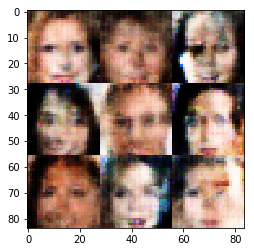

Epoch 1/1 - Step 910 -  Discriminator Loss: 1.2490 -  Generator Loss: 1.7012
Epoch 1/1 - Step 920 -  Discriminator Loss: 0.8014 -  Generator Loss: 1.4887
Epoch 1/1 - Step 930 -  Discriminator Loss: 0.8028 -  Generator Loss: 1.6183
Epoch 1/1 - Step 940 -  Discriminator Loss: 1.1087 -  Generator Loss: 0.9726
Epoch 1/1 - Step 950 -  Discriminator Loss: 0.7973 -  Generator Loss: 1.4530
Epoch 1/1 - Step 960 -  Discriminator Loss: 1.0932 -  Generator Loss: 2.1670
Epoch 1/1 - Step 970 -  Discriminator Loss: 1.0507 -  Generator Loss: 1.1491
Epoch 1/1 - Step 980 -  Discriminator Loss: 1.1620 -  Generator Loss: 1.2372
Epoch 1/1 - Step 990 -  Discriminator Loss: 1.1722 -  Generator Loss: 1.3957
Epoch 1/1 - Step 1000 -  Discriminator Loss: 0.8502 -  Generator Loss: 1.5494
Sample outputs:


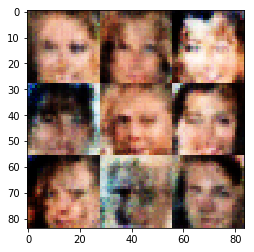

Epoch 1/1 - Step 1010 -  Discriminator Loss: 0.9445 -  Generator Loss: 1.6857
Epoch 1/1 - Step 1020 -  Discriminator Loss: 1.1172 -  Generator Loss: 1.6869
Epoch 1/1 - Step 1030 -  Discriminator Loss: 0.6760 -  Generator Loss: 1.7875
Epoch 1/1 - Step 1040 -  Discriminator Loss: 0.9696 -  Generator Loss: 1.6705
Epoch 1/1 - Step 1050 -  Discriminator Loss: 0.5800 -  Generator Loss: 2.0658
Epoch 1/1 - Step 1060 -  Discriminator Loss: 0.6460 -  Generator Loss: 1.8773
Epoch 1/1 - Step 1070 -  Discriminator Loss: 0.8867 -  Generator Loss: 1.5968
Epoch 1/1 - Step 1080 -  Discriminator Loss: 0.8665 -  Generator Loss: 1.9707
Epoch 1/1 - Step 1090 -  Discriminator Loss: 0.9839 -  Generator Loss: 2.5210
Epoch 1/1 - Step 1100 -  Discriminator Loss: 0.7423 -  Generator Loss: 1.8661
Sample outputs:


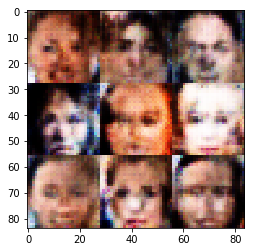

Epoch 1/1 - Step 1110 -  Discriminator Loss: 0.6418 -  Generator Loss: 1.9500
Epoch 1/1 - Step 1120 -  Discriminator Loss: 0.8657 -  Generator Loss: 1.5578
Epoch 1/1 - Step 1130 -  Discriminator Loss: 1.0005 -  Generator Loss: 2.3647
Epoch 1/1 - Step 1140 -  Discriminator Loss: 0.7379 -  Generator Loss: 1.9985
Epoch 1/1 - Step 1150 -  Discriminator Loss: 1.2663 -  Generator Loss: 1.3102
Epoch 1/1 - Step 1160 -  Discriminator Loss: 0.6813 -  Generator Loss: 2.1835
Epoch 1/1 - Step 1170 -  Discriminator Loss: 0.7054 -  Generator Loss: 2.0715
Epoch 1/1 - Step 1180 -  Discriminator Loss: 1.0804 -  Generator Loss: 0.9734
Epoch 1/1 - Step 1190 -  Discriminator Loss: 0.9398 -  Generator Loss: 2.1774
Epoch 1/1 - Step 1200 -  Discriminator Loss: 0.9080 -  Generator Loss: 2.3544
Sample outputs:


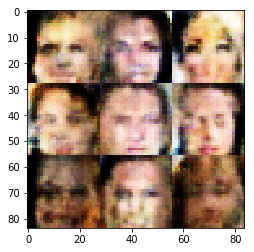

Epoch 1/1 - Step 1210 -  Discriminator Loss: 0.5917 -  Generator Loss: 2.1183
Epoch 1/1 - Step 1220 -  Discriminator Loss: 0.6217 -  Generator Loss: 1.9922
Epoch 1/1 - Step 1230 -  Discriminator Loss: 1.1596 -  Generator Loss: 2.5370
Epoch 1/1 - Step 1240 -  Discriminator Loss: 0.9797 -  Generator Loss: 1.8637
Epoch 1/1 - Step 1250 -  Discriminator Loss: 0.7976 -  Generator Loss: 2.0739
Epoch 1/1 - Step 1260 -  Discriminator Loss: 0.9154 -  Generator Loss: 1.8623
Epoch 1/1 - Step 1270 -  Discriminator Loss: 0.7463 -  Generator Loss: 2.1655
Epoch 1/1 - Step 1280 -  Discriminator Loss: 0.9691 -  Generator Loss: 1.3914
Epoch 1/1 - Step 1290 -  Discriminator Loss: 0.6811 -  Generator Loss: 1.8113
Epoch 1/1 - Step 1300 -  Discriminator Loss: 0.9008 -  Generator Loss: 1.9587
Sample outputs:


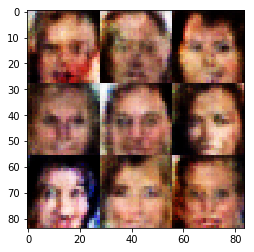

Epoch 1/1 - Step 1310 -  Discriminator Loss: 1.2932 -  Generator Loss: 1.4621
Epoch 1/1 - Step 1320 -  Discriminator Loss: 0.8804 -  Generator Loss: 1.6971
Epoch 1/1 - Step 1330 -  Discriminator Loss: 1.0202 -  Generator Loss: 2.4347
Epoch 1/1 - Step 1340 -  Discriminator Loss: 0.7769 -  Generator Loss: 1.5671
Epoch 1/1 - Step 1350 -  Discriminator Loss: 1.2434 -  Generator Loss: 2.1557
Epoch 1/1 - Step 1360 -  Discriminator Loss: 0.9064 -  Generator Loss: 1.9855
Epoch 1/1 - Step 1370 -  Discriminator Loss: 1.0456 -  Generator Loss: 1.1047
Epoch 1/1 - Step 1380 -  Discriminator Loss: 0.7192 -  Generator Loss: 1.9077
Epoch 1/1 - Step 1390 -  Discriminator Loss: 0.7387 -  Generator Loss: 1.6496
Epoch 1/1 - Step 1400 -  Discriminator Loss: 0.7067 -  Generator Loss: 2.1516
Sample outputs:


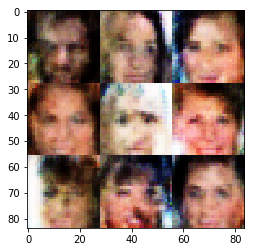

Epoch 1/1 - Step 1410 -  Discriminator Loss: 1.2705 -  Generator Loss: 2.2840
Epoch 1/1 - Step 1420 -  Discriminator Loss: 1.0854 -  Generator Loss: 2.1403
Epoch 1/1 - Step 1430 -  Discriminator Loss: 0.6632 -  Generator Loss: 1.8565
Epoch 1/1 - Step 1440 -  Discriminator Loss: 0.7283 -  Generator Loss: 1.9359
Epoch 1/1 - Step 1450 -  Discriminator Loss: 0.7511 -  Generator Loss: 1.7459
Epoch 1/1 - Step 1460 -  Discriminator Loss: 0.7323 -  Generator Loss: 2.0450
Epoch 1/1 - Step 1470 -  Discriminator Loss: 0.6773 -  Generator Loss: 1.8954
Epoch 1/1 - Step 1480 -  Discriminator Loss: 0.5908 -  Generator Loss: 2.0642
Epoch 1/1 - Step 1490 -  Discriminator Loss: 1.2302 -  Generator Loss: 1.4151
Epoch 1/1 - Step 1500 -  Discriminator Loss: 0.7847 -  Generator Loss: 1.5589
Sample outputs:


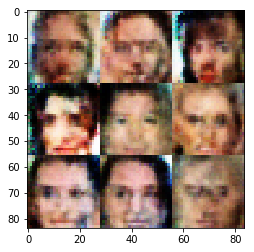

Epoch 1/1 - Step 1510 -  Discriminator Loss: 0.8497 -  Generator Loss: 1.4491
Epoch 1/1 - Step 1520 -  Discriminator Loss: 0.7277 -  Generator Loss: 2.1181
Epoch 1/1 - Step 1530 -  Discriminator Loss: 0.8683 -  Generator Loss: 1.7801
Epoch 1/1 - Step 1540 -  Discriminator Loss: 0.7935 -  Generator Loss: 1.7283
Epoch 1/1 - Step 1550 -  Discriminator Loss: 0.9230 -  Generator Loss: 1.7747
Epoch 1/1 - Step 1560 -  Discriminator Loss: 1.0083 -  Generator Loss: 1.5908
Epoch 1/1 - Step 1570 -  Discriminator Loss: 0.7694 -  Generator Loss: 2.1212
Epoch 1/1 - Step 1580 -  Discriminator Loss: 0.5294 -  Generator Loss: 2.4446
Epoch 1/1 - Step 1590 -  Discriminator Loss: 0.6703 -  Generator Loss: 1.8703
Epoch 1/1 - Step 1600 -  Discriminator Loss: 0.7378 -  Generator Loss: 1.8777
Sample outputs:


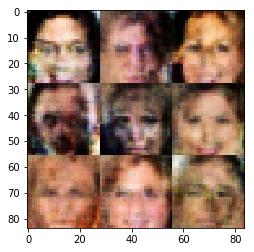

Epoch 1/1 - Step 1610 -  Discriminator Loss: 1.1639 -  Generator Loss: 1.7257
Epoch 1/1 - Step 1620 -  Discriminator Loss: 0.5965 -  Generator Loss: 2.1198
Epoch 1/1 - Step 1630 -  Discriminator Loss: 0.7054 -  Generator Loss: 2.2651
Epoch 1/1 - Step 1640 -  Discriminator Loss: 0.9783 -  Generator Loss: 1.5777
Epoch 1/1 - Step 1650 -  Discriminator Loss: 0.8165 -  Generator Loss: 1.4628
Epoch 1/1 - Step 1660 -  Discriminator Loss: 0.7161 -  Generator Loss: 1.8891
Epoch 1/1 - Step 1670 -  Discriminator Loss: 0.9140 -  Generator Loss: 2.2213
Epoch 1/1 - Step 1680 -  Discriminator Loss: 0.5961 -  Generator Loss: 2.0423
Epoch 1/1 - Step 1690 -  Discriminator Loss: 0.7807 -  Generator Loss: 2.1756
Epoch 1/1 - Step 1700 -  Discriminator Loss: 0.7827 -  Generator Loss: 1.6594
Sample outputs:


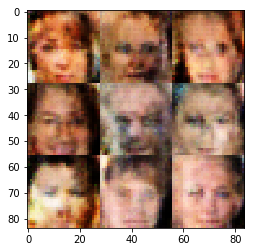

Epoch 1/1 - Step 1710 -  Discriminator Loss: 1.0214 -  Generator Loss: 1.6743
Epoch 1/1 - Step 1720 -  Discriminator Loss: 0.6407 -  Generator Loss: 1.9944
Epoch 1/1 - Step 1730 -  Discriminator Loss: 0.7198 -  Generator Loss: 1.9516
Epoch 1/1 - Step 1740 -  Discriminator Loss: 0.9812 -  Generator Loss: 1.4669
Epoch 1/1 - Step 1750 -  Discriminator Loss: 0.7244 -  Generator Loss: 1.7669
Epoch 1/1 - Step 1760 -  Discriminator Loss: 0.9941 -  Generator Loss: 1.3055
Epoch 1/1 - Step 1770 -  Discriminator Loss: 0.6675 -  Generator Loss: 2.0530
Epoch 1/1 - Step 1780 -  Discriminator Loss: 0.7472 -  Generator Loss: 1.8616
Epoch 1/1 - Step 1790 -  Discriminator Loss: 1.2010 -  Generator Loss: 1.9018
Epoch 1/1 - Step 1800 -  Discriminator Loss: 0.5972 -  Generator Loss: 2.4127
Sample outputs:


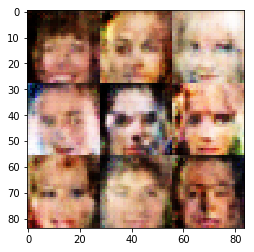

Epoch 1/1 - Step 1810 -  Discriminator Loss: 0.7735 -  Generator Loss: 1.6404
Epoch 1/1 - Step 1820 -  Discriminator Loss: 0.7298 -  Generator Loss: 1.9613
Epoch 1/1 - Step 1830 -  Discriminator Loss: 0.8199 -  Generator Loss: 1.6727
Epoch 1/1 - Step 1840 -  Discriminator Loss: 0.8463 -  Generator Loss: 1.5766


KeyboardInterrupt: 

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.